In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path

from scipy.stats import  mannwhitneyu, ks_2samp

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "10k_brain"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 

  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pt_S_v_S_tilde = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  df_top_2K = df_analy[ df_analy['rank_stat'] <= 2000 ]     
  x_cut = pd.qcut ( df_top_2K['nz_cells'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  y_cut = pd.qcut ( df_top_2K['abs_log_ratio'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  df_top_2K = df_top_2K.assign( Q_nz_cells = x_cut[0] )  
  df_top_2K = df_top_2K.assign( Q_instability = y_cut[0] )    
  pt = pv_table_noprint_margins ( df_top_2K, 'Q_instability', 'Q_nz_cells' )  
  pt_instability_v_nz_cells = ( pt.transpose() [[ 'Q4','Q3','Q2','Q1', 'Total']] ).transpose()
    
    
  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] <= 200 ].min()  
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
    
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label,  method_symbol.lower()  + ': instability' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 

  plot_ax ( df_analy, ax3, 'C', 'nz_cells', 'abs_log_ratio',  "$n_g$: nonzero cells" , method_symbol.lower()  + ': instability' ,yscale_log=False, line_slope='none' )
  

  y_min2, y_max2 = ax2.get_ylim()
  y_min3, y_max3 = ax3.get_ylim()
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max )    
  

  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return ( pt_S_v_S_tilde, pt_instability_v_nz_cells,  df_top_2K['abs_log_ratio'].values )

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_nz_cells = nru_dict['df_gene_stats'] [['nz_cells']]
print (  '\n\n df_nz_cells: ' )  
print (  '\n', df_nz_cells   )  


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
df_A_g['rank_stat'] = df_A_g['stat'].rank( ascending=False )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
df_L_g['rank_stat'] = df_L_g['stat'].rank( ascending=False )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
df_S_g['rank_stat'] = df_S_g['stat'].rank( ascending=False )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )



 df_nz_cells: 

                     nz_cells
ENSMUSG00000052305      4111
ENSMUSG00000073940      1357
ENSMUSG00000069919       959
ENSMUSG00000069917       916
ENSMUSG00000019874      6156
...                      ...
ENSMUSG00000027075       118
ENSMUSG00000026389        52
ENSMUSG00000063021        57
ENSMUSG00000032204        59
ENSMUSG00000043629       107

[13817 rows x 1 columns]


 df_A_g:  

                            stat  rank_stat
ENSMUSG00000052305  4003.436265        1.0
ENSMUSG00000073940  1188.055973        2.0
ENSMUSG00000069919   749.206331        3.0
ENSMUSG00000069917   526.798715        4.0
ENSMUSG00000019874   143.286862        5.0
...                         ...        ...
ENSMUSG00000027075     0.646999    13785.5
ENSMUSG00000026389     0.646999    13785.5
ENSMUSG00000063021     0.646999    13785.5
ENSMUSG00000032204     0.646999    13785.5
ENSMUSG00000043629     0.646999    13785.5

[13817 rows x 2 columns]


 df_L_g:  

                           stat  ran


  A_g


 df_complementary_stats_Ag

                               0            1
ENSMUSG00000052305  4058.437839  3761.437626
ENSMUSG00000073940  1172.979586  1185.830500
ENSMUSG00000069919   747.695987   696.964243
ENSMUSG00000069917   526.977457   501.441919
ENSMUSG00000019874   136.582127   135.503772
...                         ...          ...
ENSMUSG00000042010     0.709437     0.731678
ENSMUSG00000044795     0.709437     0.822816
ENSMUSG00000021287     0.709437     0.831410
ENSMUSG00000005968     0.709437     0.901153
ENSMUSG00000027075     0.709437     0.704346

[12570 rows x 2 columns]


 genes rank_stat_200:  4.789099379617575


 Table 3

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        2     24       4        0        0         0      0     30
51-100       0      3      41        6        0     

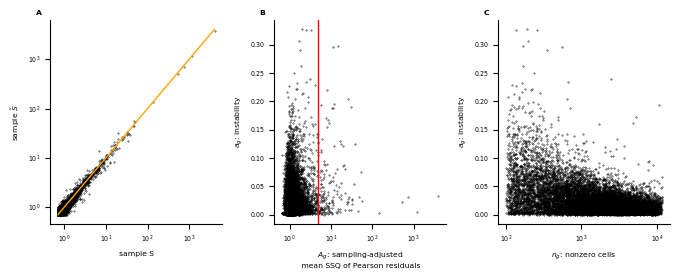

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_stats_Ag = pd.concat ( [ df_nz_cells, df_A_g ], axis=1 ) 
df_stats_Ag = df_stats_Ag.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Ag = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn )  

print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 4' )
print ( '\n', pt_instability_v_nz_cells ) 


  L_g


 df_complementary_stats_Lg

                              0           1
ENSEMBL_ID                                
ENSMUSG00000052305  180.364541  190.463192
ENSMUSG00000069919  141.031124  157.393667
ENSMUSG00000069917  133.260150  149.320511
ENSMUSG00000073940  104.043067  116.592786
ENSMUSG00000019874  103.180521  101.826492
...                        ...         ...
ENSMUSG00000099655    0.746357    0.922433
ENSMUSG00000096655    0.743417    1.200898
ENSMUSG00000029994    0.737800    0.789004
ENSMUSG00000020930    0.712552    0.799276
ENSMUSG00000110611    0.709176    0.889571

[12570 rows x 2 columns]


 genes rank_stat_200:  5.548205727375497


 Table 6

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        2     23       5        0        0         0      0     30
51-100       0      5      39    

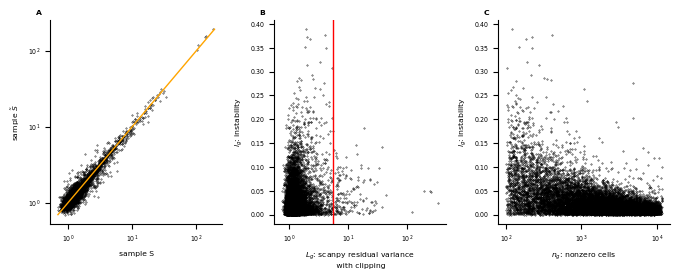

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_stats_Lg = pd.concat ( [ df_nz_cells, df_L_g ], axis=1 ) 
df_stats_Lg = df_stats_Lg.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Lg = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 

print ( '\n\n Table 6' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 7' )
print ( '\n', pt_instability_v_nz_cells ) 


  S_g


 df_complementary_stats_Sg

                            0         1
gene_vector                           
ENSMUSG00000000001  0.820194  0.739303
ENSMUSG00000000028  1.189507  1.074369
ENSMUSG00000000031  1.794471  1.445864
ENSMUSG00000000037  0.368861  0.377692
ENSMUSG00000000056  0.960984  0.896855
...                      ...       ...
ENSMUSG00000116858  0.981889  0.969725
ENSMUSG00000116883  0.575610  0.643023
ENSMUSG00000116895  0.615638  0.598965
ENSMUSG00000116951  0.285974  0.228143
ENSMUSG00000116953  0.708582  0.666517

[12570 rows x 2 columns]


 genes rank_stat_200:  5.855469316939115


 Table 9

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        15      5       0        0        0         0      0     20
21-50        5     19       6        0        0         0      0     30
51-100       0      6      36        7        1         0      0     50
101-200      

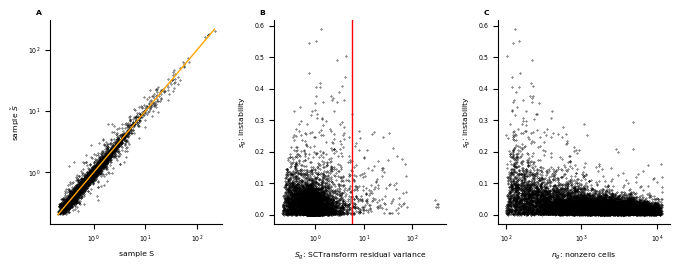

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_stats_Sg = pd.concat ( [ df_nz_cells, df_S_g ], axis=1 ) 
df_stats_Sg = df_stats_Sg.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Sg = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 

print ( '\n\n Table 9' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 10' )
print ( '\n', pt_instability_v_nz_cells ) 

In [10]:
MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='less' )   

print ( ' one-sided tests \n ---------------  \n\n null: L_g = A_g,  alternative: L_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )


MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='less' )   

print ( '\n\n null: S_g = A_g,  alternative: S_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )

 one-sided tests 
 ---------------  

 null: L_g = A_g,  alternative: L_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  1762318.0      p =  2.7239231565790216e-05

 scipy.stats.ks_2samp:  
 statistic =  1762318.0      p =  1.7946601890063647e-06


 null: S_g = A_g,  alternative: S_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  1955733.0      p =  2.0227590448609257e-07

 scipy.stats.ks_2samp:  
 statistic =  1955733.0      p =  1.682184898407232e-05
